✅ Loaded 169845 samples | 7 emotion classes.


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/135876 [00:00<?, ? examples/s]

Map:   0%|          | 0/33969 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2023411557.py:127: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.798200,0.759010,0.737761,0.742892,0.737761,0.738778
2,0.628600,0.659976,0.776031,0.788942,0.776031,0.776685
3,0.502700,0.641953,0.792340,0.795508,0.792340,0.792713



📊 Validation Metrics:
eval_loss: 0.6420
eval_accuracy: 0.7923
eval_precision: 0.7955
eval_recall: 0.7923
eval_f1: 0.7927
eval_runtime: 110.5329
eval_samples_per_second: 307.3200
eval_steps_per_second: 19.2160
epoch: 3.0000

Classification Report:

              precision    recall  f1-score   support

       anger     0.7300    0.7772    0.7529      4000
        fear     0.8676    0.8801    0.8738      4988
         joy     0.7247    0.8219    0.7702      4980
        love     0.7646    0.7667    0.7657      5826
     neutral     0.8681    0.7618    0.8115      5004
     sadness     0.8019    0.7929    0.7973      4171
    surprise     0.8045    0.7474    0.7749      5000

    accuracy                         0.7923     33969
   macro avg     0.7945    0.7926    0.7923     33969
weighted avg     0.7955    0.7923    0.7927     33969



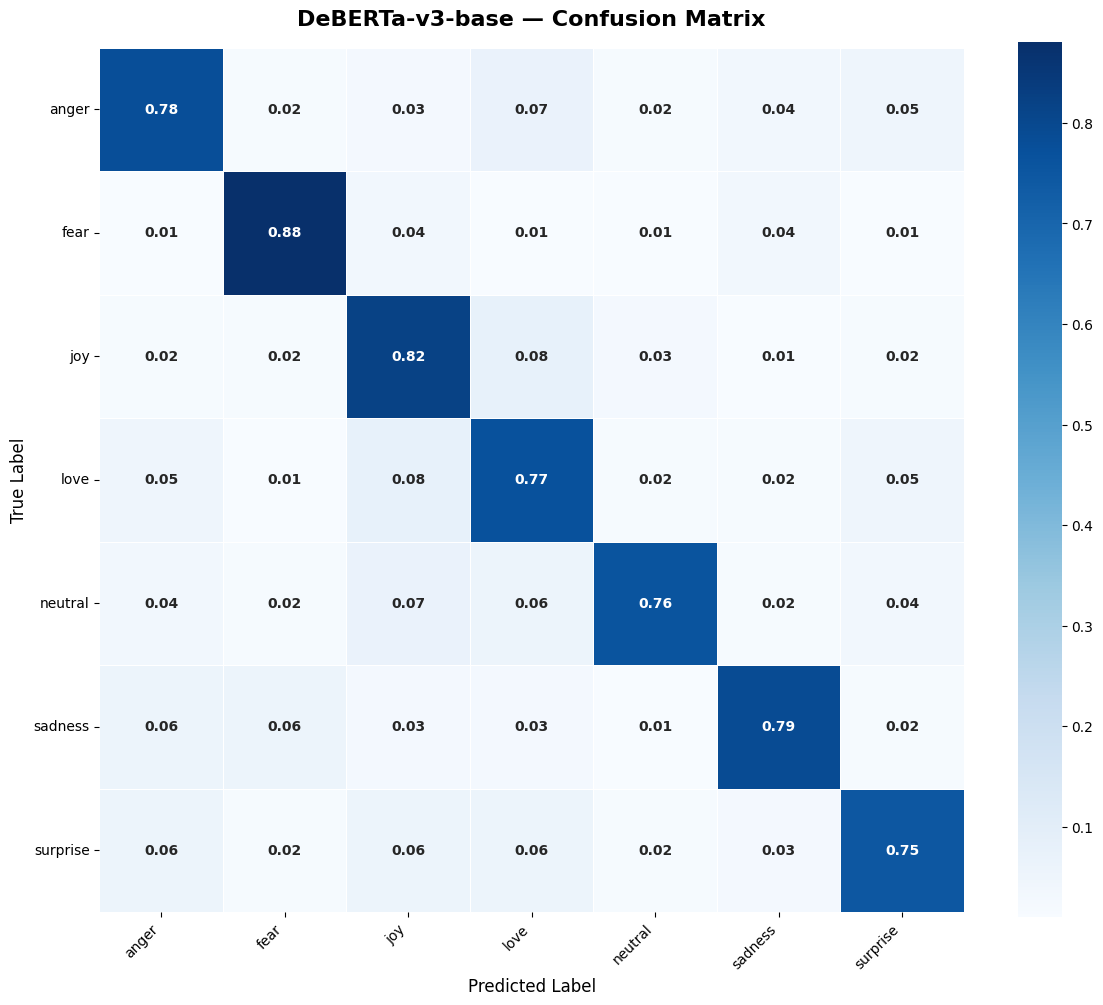

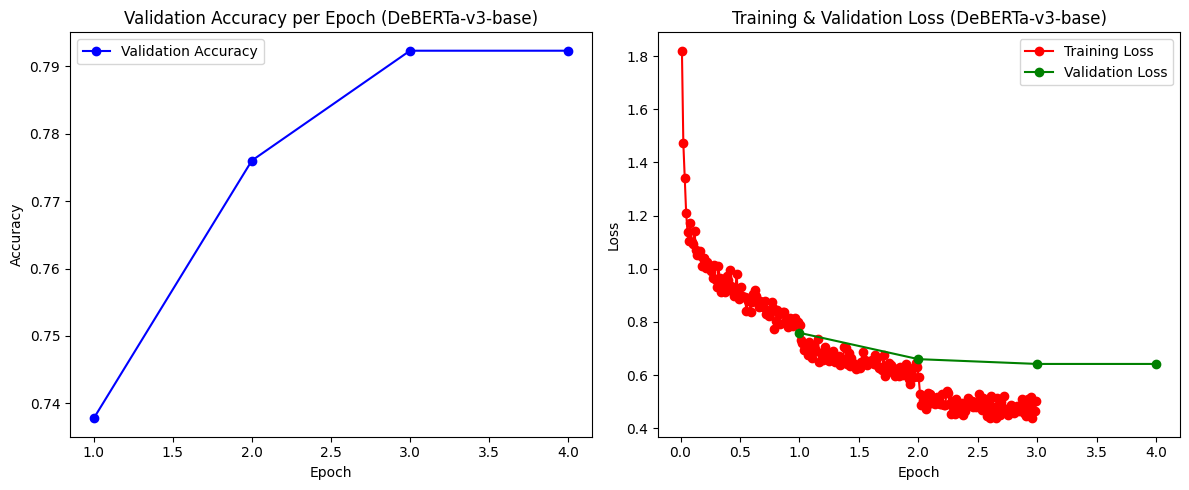


✅ DeBERTa-v3-base model, tokenizer, and label encoder saved successfully to /content


In [ ]:
# ================================================================
# 🧠 MindScape Emotion Classification — DeBERTa-v3-base
# ================================================================

import os
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# ---------------------------
# STEP 1 — Paths & Config
# ---------------------------
SAVE_DIR = "/content"
DATA_PATH = "/content/balanced_emotion_dataset.csv"

os.makedirs(SAVE_DIR, exist_ok=True)
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
SEED = 42

# ---------------------------
# STEP 2 — Reproducibility
# ---------------------------
def set_seed(seed=SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

# ---------------------------
# STEP 3 — Load Dataset
# ---------------------------
df = pd.read_csv(DATA_PATH)[["text", "emotion"]].dropna()
print(f"✅ Loaded {len(df)} samples | {df['emotion'].nunique()} emotion classes.")

le = LabelEncoder()
df["label"] = le.fit_transform(df["emotion"])
num_labels = len(le.classes_)

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED
)
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# ---------------------------
# STEP 4 — Tokenizer
# ---------------------------
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(examples):
    return tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN
    )

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# ---------------------------
# STEP 5 — Load Model
# ---------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)

# ---------------------------
# STEP 6 — Metrics
# ---------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ---------------------------
# STEP 7 — Training Arguments
# ---------------------------
training_args = TrainingArguments(
    output_dir="./results_deberta_v3",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_deberta_v3",
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

# ---------------------------
# STEP 8 — Trainer
# ---------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ---------------------------
# STEP 9 — Train
# ---------------------------
trainer.train()

# ---------------------------
# STEP 10 — Evaluate
# ---------------------------
metrics = trainer.evaluate()
print("\n📊 Validation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

# ---------------------------
# STEP 11 — Confusion Matrix
# ---------------------------
def plot_confusion_matrix(y_true, y_pred, labels, model_name="DeBERTa-v3-base"):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    cm_display = np.round(cm, 2)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_display,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        cbar=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor="white",
        square=True,
        annot_kws={"size": 10, "weight": "bold"},
    )
    plt.title(f"{model_name} — Confusion Matrix", fontsize=16, fontweight="bold", pad=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, le.classes_, model_name="DeBERTa-v3-base")

# ---------------------------
# STEP 12 — Accuracy & Loss Graphs
# ---------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc = [], [], []
epochs = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_acc.append(log["eval_accuracy"])

plt.figure(figsize=(12, 5))

# Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, marker="o", label="Validation Accuracy", color="blue")
plt.title("Validation Accuracy per Epoch (DeBERTa-v3-base)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker="o", label="Training Loss", color="red")
plt.plot(range(1, len(eval_loss) + 1), eval_loss, marker="o", label="Validation Loss", color="green")
plt.title("Training & Validation Loss (DeBERTa-v3-base)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------
# STEP 13 — Save Model
# ---------------------------
model.save_pretrained(f"{SAVE_DIR}/DeBERTa_v3_MindScape")
tokenizer.save_pretrained(f"{SAVE_DIR}/DeBERTa_v3_MindScape")
with open(f"{SAVE_DIR}/DeBERTa_v3_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"\n✅ DeBERTa-v3-base model, tokenizer, and label encoder saved successfully to {SAVE_DIR}")

In [ ]:
# ================================================================
# STEP 14 — Real-Time Prediction / Inference
# ================================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# ---------- Load saved model and tokenizer ----------
MODEL_PATH = f"{SAVE_DIR}/DeBERTa_v3_MindScape"
LABEL_ENCODER_PATH = f"{SAVE_DIR}/DeBERTa_v3_label_encoder.pkl"

# Load model + tokenizer + label encoder
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
with open(LABEL_ENCODER_PATH, "rb") as f:
    le = pickle.load(f)

# ---------- Prediction Function ----------
def predict_emotion(texts, model=model, tokenizer=tokenizer, label_encoder=le, max_len=128):
    """
    Predict emotion(s) for given text or list of texts.
    """
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).cpu().numpy()
        confidences = probs.max(dim=-1).values.cpu().numpy()

    decoded_preds = label_encoder.inverse_transform(preds)
    results = [
        {"text": t, "predicted_emotion": p, "confidence": round(float(c), 4)}
        for t, p, c in zip(texts, decoded_preds, confidences)
    ]
    return results


In [ ]:
text = "I feel completely lost lately, like everything I cared about is slipping away no matter how hard I try to hold on. The silence in my room feels heavier each night, and it scares me how familiar that emptiness has become. Sometimes I wake up with my heart racing, terrified that nothing in my life will ever change for the better. I try to stay strong, but the truth is, I’m exhausted from pretending I’m okay when I’m breaking inside. Every message I don’t get, every call that never comes, makes me feel more invisible than before. And the worst part is, I’m starting to believe that maybe I deserve this loneliness "
result = predict_emotion(text)
print(result)


[{'text': 'I feel completely lost lately, like everything I cared about is slipping away no matter how hard I try to hold on. The silence in my room feels heavier each night, and it scares me how familiar that emptiness has become. Sometimes I wake up with my heart racing, terrified that nothing in my life will ever change for the better. I try to stay strong, but the truth is, I’m exhausted from pretending I’m okay when I’m breaking inside. Every message I don’t get, every call that never comes, makes me feel more invisible than before. And the worst part is, I’m starting to believe that maybe I deserve this loneliness ', 'predicted_emotion': 'fear', 'confidence': 0.9958}]


In [ ]:
# ================================================================
# STEP 15 — Save All Outputs to Google Drive
# ================================================================

from google.colab import drive
import shutil
import os

# 🔗 Mount Google Drive
drive.mount('/content/drive')

# Source paths
src_model_dir = "/content/DeBERTa_v3_MindScape"
src_label_encoder = "/content/DeBERTa_v3_label_encoder.pkl"
src_results_dir = "/content/results_deberta_v3"

# Destination paths in Drive
drive_base = "/content/drive/MyDrive/MindScape_Models/DeBERTa_v3"
drive_model_dir = os.path.join(drive_base, "Model")
drive_results_dir = os.path.join(drive_base, "Results")

# Create folders if they don't exist
os.makedirs(drive_model_dir, exist_ok=True)
os.makedirs(drive_results_dir, exist_ok=True)

# Copy model folder
if os.path.exists(src_model_dir):
    shutil.copytree(src_model_dir, os.path.join(drive_model_dir, "DeBERTa_v3_MindScape"), dirs_exist_ok=True)
    print("✅ Model folder copied successfully!")

# Copy label encoder
if os.path.exists(src_label_encoder):
    shutil.copy(src_label_encoder, drive_model_dir)
    print("✅ Label encoder copied successfully!")

# Copy results directory
if os.path.exists(src_results_dir):
    shutil.copytree(src_results_dir, drive_results_dir, dirs_exist_ok=True)
    print("✅ Results folder copied successfully!")

print(f"\n📁 All files saved to Google Drive at: {drive_base}")


Mounted at /content/drive
✅ Model folder copied successfully!
✅ Label encoder copied successfully!
✅ Results folder copied successfully!

📁 All files saved to Google Drive at: /content/drive/MyDrive/MindScape_Models/DeBERTa_v3
